# Chapter 6. Performance analysis by server elimination

This Notebook computes and plots the numerical results for Chapter 6 of the Ph.D. thesis. Sections 1 and 2 of this Notebook define functions for computing the results, while Sections 3 and 4 plot them. For each section, we add a pointer to the corresponding section or subsection in the manuscript.

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
folder = "data/"

## 1. Random customer assignment (Section 6.2)

### Homogeneous queue (Subsection 6.2.1)

$$
\psi = \prod_{s=r}^S \left( 1 - \rho_{|s} \right)
\quad \text{and} \quad
L = \sum_{s=r}^S \frac{ \rho_{|s} }{ 1 - \rho_{|s} },
$$
where
$$
\rho_{|s}
= \frac1{s \mu} \frac{ \binom{s}{r_n} }{ \binom{S}{r_n} } S \lambda
= \rho \frac{ \binom{s-1}{r_n-1} }{ \binom{S-1}{r_n-1} }
$$
is the load in the subsystem restricted to $s$ arbitrary servers.

We just need to compute
$$
    b_s = \binom{s-1}{r-1}
$$
for each $s = r,\ldots,S$.
We have $b_r = 1$ and, for each $s = r+1,\ldots,S$,
$$
    b_s
    = \frac{ (s-1)! }{ (r-1)! (s-r)! }
    = \frac{s-1}{s-r} \frac{ ((s-1)-1)! }{ (r-1)! ((s-1)-r)! }
    = \left( 1 + \frac{r-1}{s-r} \right) b_{s-1}.
$$
We use this last equality to compute recursively $b_s$ for each $s = r+1,\ldots,S$.

In [3]:
def global_homogeneous(S=10, r=3, ρ=.5):
    binom = ones(S - r + 1, dtype=float)
    binom[1:] = cumprod(1 + (r-1) / arange(1, S - r + 1))
    binom /= binom[-1]
    ρs = ρ * binom
    return sum(ρs / (1 - ρs))

### Heterogeneous degrees (Subsection 6.2.2)

$$
\psi = \prod_{s=r}^S \left( 1 - \rho_{|s} \right)
\quad \text{and} \quad
L = \sum_{s=r}^S \frac{ \rho_{|s} }{ 1 - \rho_{|s} },
$$
where
$$
\rho_{|s} = \frac1{ s \mu }
\sum_{n=1}^N \frac{ \binom{s}{r_n} }{ \binom{S}{r_n} } S \lambda p_n
= \rho \sum_{n=1}^N \frac{ \binom{s-1}{r_n-1} }{ \binom{S-1}{r_n-1} } p_n
$$
is the load in the subsystem restricted to $s$ arbitrary servers.

Implementation: We let
$$
b_{n,s} = p_n \frac{ \binom{s}{r_n} }{ \binom{S}{r_n} },
$$
and we compute it by induction on $s$ for each $n$, using the formula:
$$
\binom{s}{r} = \left( 1 + \frac{r-1}{s-r} \right) \times \binom{s-1}{r}.
$$
Then we let $w_s = \sum_{n=1}^N b_{n,s}$ for each $s = 1,\ldots,S$.

We can express all the metrics as functions of these quantities:
\begin{align*}
\rho_s &= \rho \times w_s, \\
\psi &= \prod_{s=1}^S (1 - \rho_{s}), \\
L &= \sum_{s=1}^S \frac{ \rho_{|s} }{ 1 - \rho_{|s} }, \\
\rho_{n|s} &= \frac{ \rho \times b_{n,s} }{ 1 - \rho (w_s - b_{n,s}) }, \\
L_n &= \sum_{s=r_n}^S \frac{ \rho_{n|s} }{ 1 - \rho_{n|s} }
\end{align*}

In [4]:
def global_heterogeneous(S, r, p, ρ):
    K = len(r);
    b = zeros((K, S), dtype=float)
    for k in range(K):
        b[k, r[k] - 1] = 1.
        b[k, r[k]:] = cumprod(1 + (r[k] - 1) / arange(1, S - r[k] + 1))
        b[k, :] *= p[k] / b[k, -1]
    w = sum(b, axis=0)  # sum for all k = 1,...,K

    Ln = zeros(K)

    ρs = ρ * w
    ψ = prod(1. - ρs)
    L = sum(ρs / (1. - ρs))
    for k in range(K):
        ρns = ρ * b[k, :] / (1. - ρ * (w - b[k, :]))
        Ln[k] = sum(ρns / (1. - ρns))

    return ψ, L / S / ρ, Ln / S / ρ / p

## 2. Local assignment (Section 6.3)

### Random customer assignment (Subsection 6.3.3)

In a homogeneous, local, randomized load balancing system of parameters $ S $, $ r $ and $ \rho =\frac{\lambda}{\mu} $, the stability condition is $ \rho < 1 $. Defining $ \rho_{|s} = \frac{1-\frac{r-1}{s}}{1-\frac{r-1}{S}}\rho$, the probability that the system is empty is $\psi = \psi_{|1..S}$ , with
	$$
	\psi_{|1..s} = \left\{
	\begin{array}{l}
	1 \text{ if } s < r\text{,}\\
	(1-\rho_{|s})\frac{s}{\sum_{t=1}^{s}\frac{1}{\psi_{|1..t-1}\psi_{|1..s-t}}}
	\text{ otherwise.}
	\end{array}
	 \right.
	$$

In [5]:
def line_ψ(S=10, r=3, ρ=.5):
    ψ = ones(S + 1)
    for s in range(r, S + 1):
        ρs = ρ * (1 - (r - 1) / s) / (1 - (r - 1) / S)
        ψ[s] = (1 - ρs) * s / sum([1 / ψ[t-1] / ψ[s-t] for t in range(1, s+1)])
    return ψ

For each $t \in 1..S-r+1$, the mean number of class-$t$ jobs in the system is $L_{t} = L_{t|1..S}$, with
\begin{equation}
L_{t|1..s} =
\frac{\frac{\rho_{|S}}{1-\frac{r-1}{S}}		
+\psi_{|1..s}\left(
\sum\limits_{u=1}^{t-1}\frac{L_{t-u|1..\ell-u}}{\psi_{|1..u-1}\psi_{|1..s-u}}
	+
\sum\limits_{u=t+r}^{s}\frac{L_{t|1..u-1}}{\psi_{|1..u-1}\psi_{|1..s-u}}
\right)
}{\ell(1-\rho_{|s})}\text{,}
\end{equation}

In [6]:
def line_Li(S=10, r=3, ρ=.5):
    ψ = line_ψ(S, r, ρ)
    Lt = zeros([S - r + 2, S + 1])
    for t in range(1, S - r + 2):
        for s in range(t + r - 1, S + 1):
            ρs = ρ * (1 - (r - 1) / s) / (1 - (r - 1) / S)
            Lt[t, s] = ((ρ / (1 - (r - 1) / S)
                        + ψ[s] * (sum([Lt[t-u, s-u] / ψ[u-1] / ψ[s-u] for u in range(1, t)])
                                  + sum([Lt[t, u-1] / ψ[u-1] / ψ[s-u] for u in range(t+r, s+1)])))
                       / s / (1 - ρs))
    return Lt[1:,-1]

The total mean number of jobs in the system is $L = L_{|1..S}$, with
\begin{equation}
L_{|1..\ell} = \frac{
		\rho_{|\ell}+\frac{\psi_{|1..\ell}}{\ell}\sum_{k=1}^{\ell}\frac{L_{|1..k-1}+L_{|1..\ell-k}}{\psi_{|1..k-1}\psi_{|1..\ell-k}}
	}{1-\rho_{|\ell}
}\text{.}
\end{equation}

We check with a specific function that it matches the Lis

In [7]:
def line_L(S=10, r=3, ρ=.5):
    ψ = line_ψ(S, r, ρ)
    L = zeros(S + 1)
    for s in range(r, S + 1):
        ρs = ρ * (1 - (r - 1) / s) / (1 - (r - 1) / S)
        L[s] = (ρs + ψ[s] / s * sum([(L[t-1] + L[s-t]) / ψ[t-1] / ψ[s-t]
                                     for t in range(1, s + 1)])) / (1 - ρs)
    return L[-1]

### Ring queue (Subsection 6.3.4)

In [8]:
def ring(S=10, r=3, ρ=.5):
    return ρ / (1 - ρ) + line_L(S - 1, r, (1 - (r - 1) / (S - 1)) * ρ)

## 3. Gain of differentiation (Subsection 6.4.1)

### Impact of load

In [9]:
def diff_study(S=100, step=.001):
    ρρ = arange(step, 1, step)
    I = len(ρρ)
    r6 = zeros(I)
    r8 = zeros(I)
    r9 = zeros(I)
    r12 = zeros(I)
    rm = zeros(I)
    r6m = zeros(I)
    r12m = zeros(I)

    for i, ρ in enumerate(ρρ):
        _, r6[i], _ = global_heterogeneous(S, [4], [1], ρ)  # 6
        _, r8[i], _ = global_heterogeneous(S, [8], [1], ρ)
        _, r9[i], _ = global_heterogeneous(S, [9], [1], ρ)
        _, r12[i], _ = global_heterogeneous(S, [14], [1], ρ)  # 12
        _, rm[i], R = global_heterogeneous(S, [4, 14], [.5, .5], ρ)  # mix
        r6m[i] = R[0]
        r12m[i] = R[1]
    csv = pd.DataFrame({'rho': ρρ, 'd6': r6, 'd8': r8, 'd9': r9,
                        'd12': r12, 'd6m': r6m, 'd12m': r12m, 'dm': rm})
    fn = folder + "hetero1_" + str(S) + ".csv"
    csv.to_csv(fn, index=False)

In [10]:
diff_study()

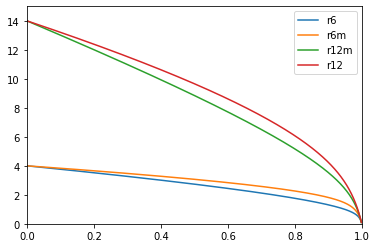

In [11]:
csv = pd.read_csv(folder + "hetero1_100.csv")
plot(csv['rho'].values, 1 / csv['d6'].values, label="r6")
plot(csv['rho'].values, 1 / csv['d6m'].values, label="r6m")
plot(csv['rho'].values, 1 / csv['d12m'].values, label="r12m")
plot(csv['rho'].values, 1 / csv['d12'].values, label="r12")
xlim([0, 1])
ymin, ymax = ylim()   # return the current ylim
ylim( (0, 15) )  # set the ylim to ymin, ymax
legend(loc='best')
show()

### Impact of population distribution

In [12]:
S = 100
step = .001
ρl = .2
ρm = .9
ρh = .99

pp = arange(step, 1, step)
I = len(pp)
r6l = zeros(I)
r12l = zeros(I)
r6m = zeros(I)
r12m = zeros(I)
r6h = zeros(I)
r12h = zeros(I)

classe = [6, 12]

for i, p in enumerate(pp):
    _, _, r = global_heterogeneous(S, classe, [p, 1 - p], ρl)
    r6l[i] = r[0]
    r12l[i] = r[1]
    _, _, r = global_heterogeneous(S, classe, [p, 1 - p], ρm)
    r6m[i] = r[0]
    r12m[i] = r[1]
    _, _, r = global_heterogeneous(S, classe, [p, 1 - p], ρh)
    r6h[i] = r[0]
    r12h[i] = r[1]
csv = pd.DataFrame({'p': pp, 'r6l': r6l, 'r12l': r12l, 'r6m': r6m,
                    'r12m': r12m, 'r6h': r6h, 'r12h': r12h})
fn = folder + "hetero2.csv"
csv.to_csv(fn, index=False)

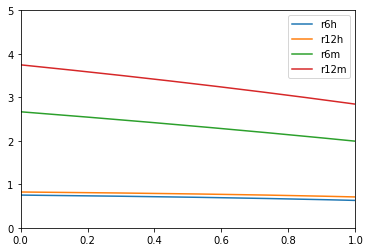

In [13]:
csv = pd.read_csv(folder + "hetero2.csv")
plot(csv['p'].values, 1 / csv['r6h'].values, label="r6h")
plot(csv['p'].values, 1 / csv['r12h'].values, label="r12h")
plot(csv['p'].values, 1 / csv['r6m'].values, label="r6m")
plot(csv['p'].values, 1 / csv['r12m'].values, label="r12m")
xlim([0, 1])
ymin, ymax = ylim() # return the current ylim
ylim( (0, 5) ) # set the ylim to ymin, ymax
legend(loc='best')
show()

## 4. Impact of locality (Subsection 6.4.2)

### Cost of heterogeneity and locality

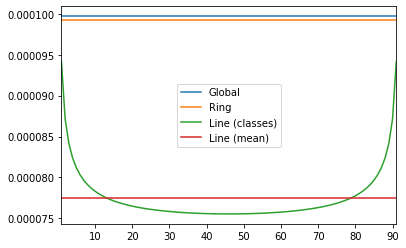

In [14]:
S = 100
r = 10
ρ = .9999

Ls = line_Li(S, r, ρ)
ring_delay = ring(S, r, ρ)
range_a = line_L(S, r, ρ)
range_i = Ls * (S - r + 1)
R = global_homogeneous(S, r, ρ)

plot([1, S - r + 1], 1. / (R * ones(2)), label="Global")
plot([1, S - r + 1], 1. / (ring_delay * ones(2)), label="Ring")
plot(range(1, S - r + 2), 1. / range_i, label="Line (classes)")
plot([1, S - r + 1], 1. / (range_a * ones(2)), label="Line (mean)")
xlim([1, S - r + 1])
legend(loc='best')
show()

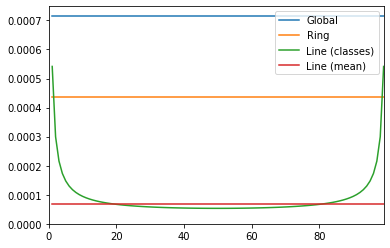

In [15]:
S = 100
r = 2
ρ = .999

Ls = line_Li(S, r, ρ)
ring_delay = ring(S, r, ρ)
range_a = line_L(S, r, ρ)
range_i = Ls * (S - r + 1)
R = global_homogeneous(S, r, ρ)

plot([1, S - r + 1], 1. / (R * ones(2)), label="Global")
plot([1, S - r + 1], 1. / (ring_delay * ones(2)), label="Ring")
plot(range(1, S - r + 2), 1. / range_i, label="Line (classes)")
plot([1, S - r + 1], 1. / (range_a * ones(2)), label="Line (mean)")
xlim([0, S - r + 1])
ymin, ymax = ylim()   # return the current ylim
ylim( (0, ymax) )  # set the ylim to ymin, ymax
legend(loc='best')
show()

In [16]:
def load_study(S=100, r=10, ρ = .9):
    c = arange(1, S - r + 2)
    Li = line_Li(S, r, ρ) * (S - r + 1) / S / ρ
    L = line_L(S, r, ρ) / S / ρ * ones(S - r + 1)
    R = ring(S, r, ρ) / S / ρ * ones(S - r + 1)
    G = global_homogeneous(S, r, ρ) / S / ρ * ones(S - r + 1)
    csv = pd.DataFrame({'c': c, 'Li': Li, 'L': L, 'R': R, 'G': G})
    csv.to_csv(folder + "load_study_S_" + str(S) + "_r_" + str(r) + "_rho_" + str(ρ) + ".csv",
               index=False)

In [17]:
def plot_local_study(S=100, r=10, ρ=.9):
    try:
        csv = pd.read_csv(folder + "load_study_S_" + str(S)
                          + "_r_" + str(r) + "_rho_" + str(ρ) + ".csv")
    except:
        load_study(S, r, ρ)
        csv = pd.read_csv(folder + "load_study_S_" + str(S)
                          + "_r_" + str(r) + "_rho_" + str(ρ) + ".csv")
    plot(csv['c'].values, 1. / csv['G'].values, label="Global")
    plot(csv['c'].values, 1. / csv['R'].values, label="Ring")
    plot(csv['c'].values, 1. / csv['L'].values, label="Line (Mean)")
    plot(csv['c'].values, 1. / csv['Li'].values, label="Line (Classes)")
    xlim([1, S - r + 1])
    legend(loc='best')
    show()

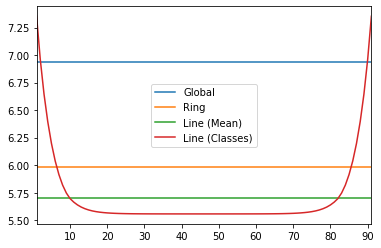

In [18]:
plot_local_study(ρ=.5)

### Impact of the parameters

#### Load $\rho$

In [19]:
def load_study_rho(S=100, r=10, step=.001):
    ρρ = arange(step, 1, step)
    I = len(ρρ)
    L = zeros(I)
    R = zeros(I)
    G = zeros(I)
    for i, ρ in enumerate(ρρ):
        norm = S * ρ
        L[i] = line_L(S, r, ρ) / norm
        R[i] = ring(S, r, ρ) / norm
        G[i] = global_homogeneous(S, r, ρ) / norm
    csv = pd.DataFrame({'rho': ρρ, 'L': L, 'R': R, 'G': G})
    csv.to_csv(folder + "load_study_rho_S_" + str(S) + "_r_" + str(r) + ".csv",
               index=False)

In [20]:
def plot_local_study_rho(S=100, r=10, step=.001):
    try:
        csv = pd.read_csv(folder + "load_study_rho_S_" + str(S) + "_r_" + str(r) + ".csv")
    except:
        load_study_rho(S, r, step)
        csv = pd.read_csv(folder + "load_study_rho_S_" + str(S) + "_r_" + str(r) + ".csv")
    plot(csv['rho'].values, 1. / csv['G'].values, label="Global")
    plot(csv['rho'].values, 1. / csv['R'].values, label="Ring")
    plot(csv['rho'].values, 1. / csv['L'].values, label="Line")
    xlim([0,1]); ylim(ymin=0)
    legend(loc='best')
    show()

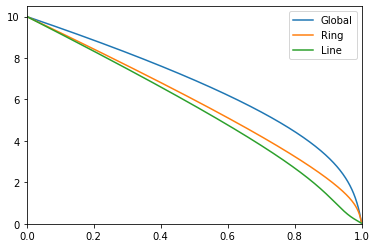

In [21]:
plot_local_study_rho(100, 10, step=.001)

#### Parallelism degree $r$

In [22]:
def load_study_r(S=100, ρ=.9):
    rr = arange(1, S+1)
    I = len(rr)
    L = zeros(I)
    R = zeros(I)
    G = zeros(I)
    for i, r in enumerate(rr):
        norm = S * ρ
        L[i] = line_L(S, r, ρ) / norm
        R[i] = ring(S, r, ρ) / norm
        G[i] = global_homogeneous(S, r, ρ) / norm
    csv = pd.DataFrame({'r': rr, 'L': L, 'R': R, 'G': G})
    csv.to_csv(folder + "load_study_r_S_" + str(S) + "_rho_" + str(ρ) + ".csv",
               index=False)

In [23]:
def plot_local_study_r(S=100, ρ=.9):
    try:
        csv = pd.read_csv(folder + "load_study_r_S_" + str(S) + "_rho_" + str(ρ) + ".csv")
    except:
        load_study_r(S, ρ)
        csv = pd.read_csv(folder + "load_study_r_S_" + str(S) + "_rho_" + str(ρ) + ".csv")
    plot(csv['r'].values, 1. / csv['G'].values, label="Global")
    plot(csv['r'].values, 1. / csv['R'].values, label="Ring")
    plot(csv['r'].values, 1. / csv['L'].values, label="Line")
    xlim([1,S]); ylim(ymin=0)
    legend(loc='best')
    show()

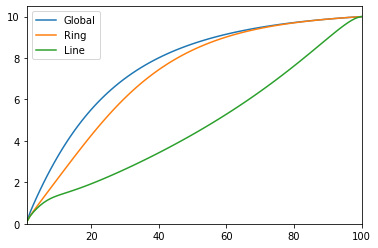

In [24]:
plot_local_study_r(100, .9)

#### Number $S$ of servers

In [25]:
def load_study_S(Smax=100, r=10, ρ=.9):
    SS = arange(r + 1, Smax + 1)
    I = len(SS)
    L = zeros(I)
    R = zeros(I)
    G = zeros(I)
    for i, S in enumerate(SS):
        norm = S * ρ
        L[i] = line_L(S, r, ρ) / norm
        R[i] = ring(S, r, ρ) / norm
        G[i] = global_homogeneous(S, r, ρ) / norm
    csv = pd.DataFrame({'S': SS, 'L': L, 'R': R, 'G': G})
    csv.to_csv(folder + "load_study_S_Smax_" + str(Smax)
               + "_r_" + str(r) + "_rho_" + str(ρ) + ".csv",
               index=False)

In [26]:
def plot_local_study_S(Smax=100, r=10, ρ=.9):
    try:
        csv = pd.read_csv(folder + "load_study_S_Smax_" + str(Smax)
                          + "_r_" + str(r) + "_rho_" + str(ρ) + ".csv")
    except:
        load_study_S(Smax, r, ρ)
        csv = pd.read_csv(folder + "load_study_S_Smax_" + str(Smax)
                          + "_r_" + str(r) + "_rho_" + str(ρ) + ".csv")
    plot(csv['S'].values, 1 / csv['G'].values, label="Global")
    plot(csv['S'].values, 1 / csv['R'].values, label="Ring")
    plot(csv['S'].values, 1 / csv['L'].values, label="Line")
    xlim([r + 1, Smax]); ylim(ymin=0)
    legend(loc='best')
    show()

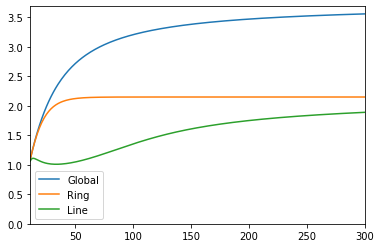

In [27]:
plot_local_study_S(300)